# Visualizing Airborne Lidar Data 

In [1]:
import warnings
warnings.filterwarnings("ignore") # suppress warnings

In [2]:
import os
import sys
import h5py
import laspy
import pyproj
import datetime 
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as ctx  # For adding a basemap
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from scipy.interpolate import griddata
from shapely.geometry import Point, box
from geoviews import opts, tile_sources as gvts
from sliderule import sliderule, icesat2, earthdata

In [3]:
# function_path = os.path.expanduser("~/geoscience/carbon_estimation/code/functions")
# sys.path.append(function_path)

# # Explicitly set the GDAL_DATA environment variable to point to the correct data directory
# # os.environ['GDAL_DATA'] = '/bsuhome/tnde/miniconda3/envs/veg_height/share/gdal'
# # os.environ['GDAL_DATA'] = '/bsuhome/tnde/miniconda3/envs/lpdaac_tutorials/share/gdal'

# # Check the default PROJ data directory
# print(pyproj.datadir.get_data_dir())
# # # If needed, explicitly set the PROJ data directory before running the script. This might not be necessary for everyone
# # pyproj.datadir.set_data_dir("/bsuhome/tnde/miniconda3/envs/lpdaac_tutorials/share/proj") # This manually set the PROJ data directory if the correct grid transformation does not appear.
# # pyproj.datadir.set_data_dir("/bsuhome/tnde/miniconda3/envs/veg_height/share/proj") # This manually set the PROJ data directory if the correct grid transformation does not appear.

## Loading Airborne Lidar Data

In [4]:
%%time
# Specify the path to your .laz file
laz_file_path = "/bsuhome/tnde/scratch/carbon_estimation/airborne_lidar/test_laz/USGS_LPC_ID_SouthernID_2018_D19_11TNH160700.laz"

# Load the .laz file
laz_data = laspy.read(laz_file_path)

# Print basic info about the data
print(laz_data)

<LasData(1.4, point fmt: <PointFormat(6, 0 bytes of extra dims)>, 28401704 points, 1 vlrs)>
CPU times: user 22.8 s, sys: 515 ms, total: 23.4 s
Wall time: 1 s


In [5]:
# List all available attributes in the .laz file
attributes = list(laz_data.point_format.dimension_names)
print("Attributes in the .laz file:", attributes)

Attributes in the .laz file: ['X', 'Y', 'Z', 'intensity', 'return_number', 'number_of_returns', 'synthetic', 'key_point', 'withheld', 'overlap', 'scanner_channel', 'scan_direction_flag', 'edge_of_flight_line', 'classification', 'user_data', 'scan_angle', 'point_source_id', 'gps_time']


## Accessing the Data Attributes

In [6]:
# Access X, Y, Z coordinates
x_coords = laz_data.x
y_coords = laz_data.y
z_coords = laz_data.z

print(f"First 5 points - X: {x_coords[:5]}, Y: {y_coords[:5]}, Z: {z_coords[:5]}")

First 5 points - X: <ScaledArrayView([517499.65 517491.68 517499.68 517491.98 517496.02])>, Y: <ScaledArrayView([4770292.3  4770314.08 4770338.48 4770310.99 4770312.19])>, Z: <ScaledArrayView([1811.61 1812.78 1803.73 1813.02 1812.76])>


In [7]:
# Inspecting other attributes
print(f"Number of points: {len(laz_data)}")
print(f"Point returns: {laz_data.return_number}")


Number of points: 28401704
Point returns: <SubFieldView([1 2 2 ... 1 1 2])>


## Visualizing the Data

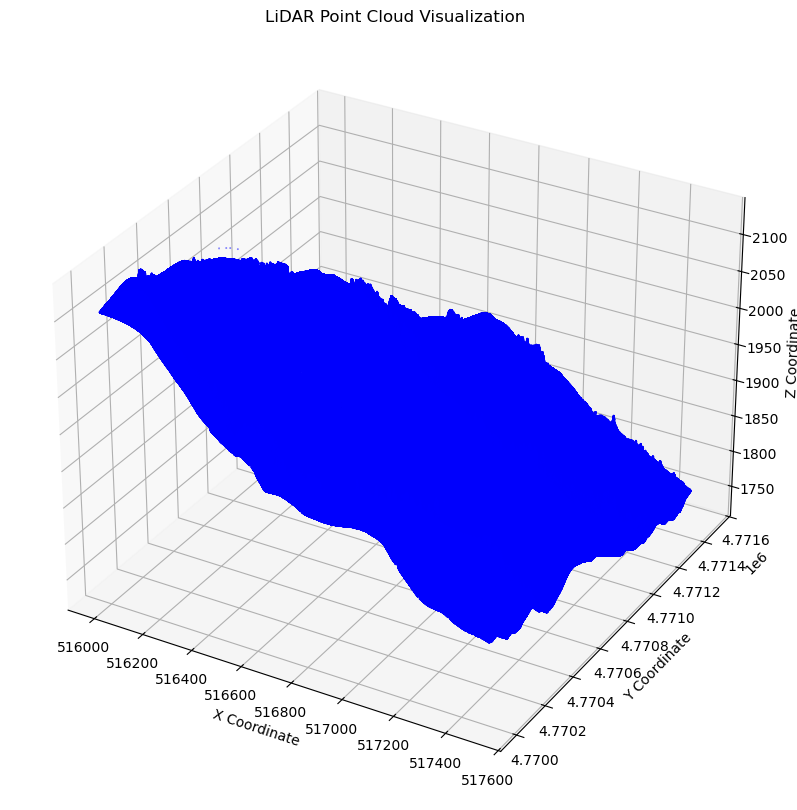

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection="3d")

# Scatter plot of the X, Y, Z coordinates
ax.scatter(laz_data.x, laz_data.y, laz_data.z, s=0.1, c="blue")

# Set labels
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_zlabel("Z Coordinate")

plt.title("LiDAR Point Cloud Visualization")
plt.show()

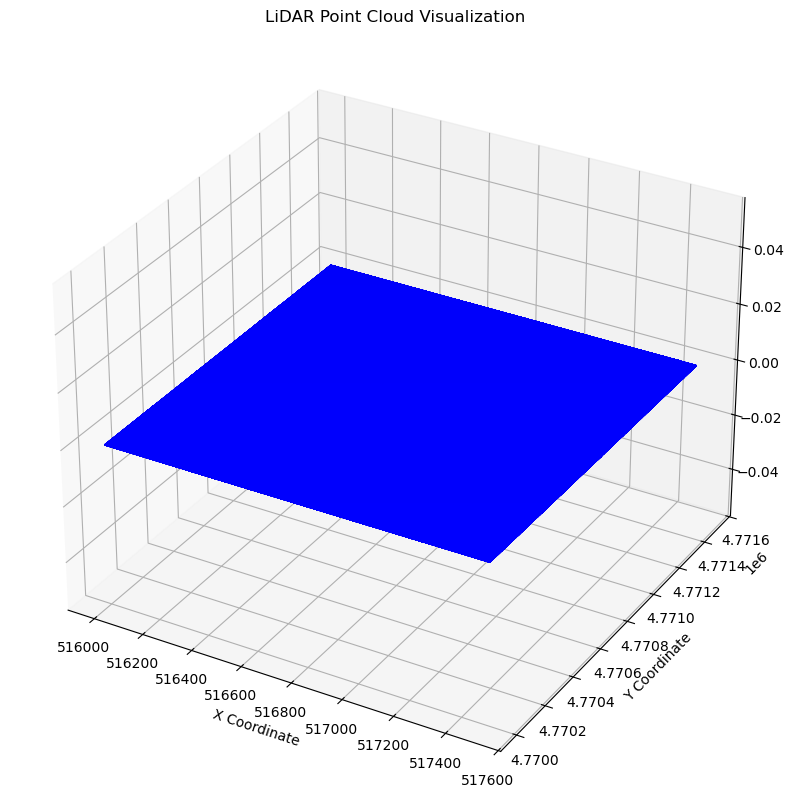

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection="3d")

# Scatter plot of the X, Y, Z coordinates
ax.scatter(laz_data.x, laz_data.y, s=0.1, c="blue")

# Set labels
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")

plt.title("LiDAR Point Cloud Visualization")
plt.show()

In [ ]:
# Calculate the bounding box
bounding_box = {
    "x_min": np.min(laz_data.x),  # Minimum X coordinate
    "x_max": np.max(laz_data.x),  # Maximum X coordinate
    "y_min": np.min(laz_data.y),  # Minimum Y coordinate
    "y_max": np.max(laz_data.y),  # Maximum Y coordinate
    "z_min": np.min(laz_data.z),  # Minimum Z coordinate
    "z_max": np.max(laz_data.z)   # Maximum Z coordinate
}

# Print the bounding box
print("Bounding Box Coordinates:")
print(f"X Min: {bounding_box['x_min']}, X Max: {bounding_box['x_max']}")
print(f"Y Min: {bounding_box['y_min']}, Y Max: {bounding_box['y_max']}")
print(f"Z Min: {bounding_box['z_min']}, Z Max: {bounding_box['z_max']}")

Bounding Box Coordinates:
X Min: 516000.0, X Max: 517499.99
Y Min: 4770000.0, Y Max: 4771499.99
Z Min: 1735.93, Z Max: 2121.31


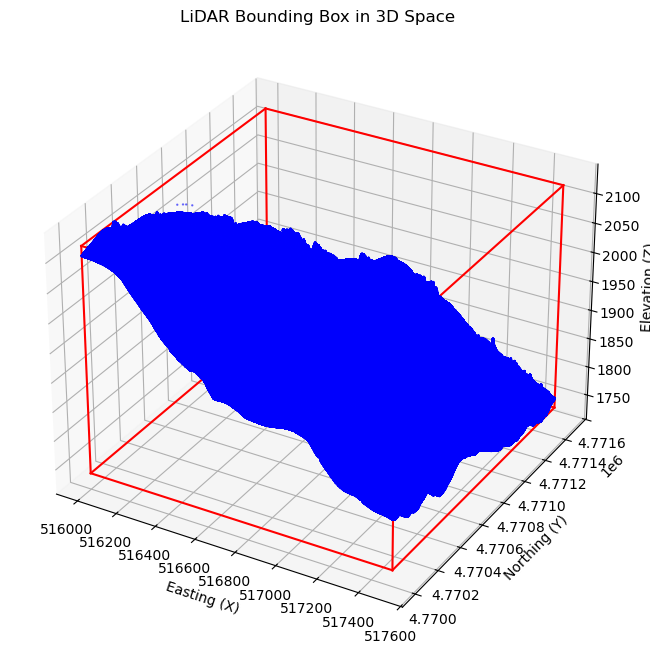

In [11]:
from mpl_toolkits.mplot3d import Axes3D

# Extract the X, Y, Z coordinates
x = laz_data.x
y = laz_data.y
z = laz_data.z

# Calculate the bounding box for X, Y, Z coordinates
x_min, x_max = np.min(x), np.max(x)
y_min, y_max = np.min(y), np.max(y)
z_min, z_max = np.min(z), np.max(z)

# Create a 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")

# Scatter plot of the LiDAR points
ax.scatter(x, y, z, s=0.5, c="blue", alpha=0.5, label="LiDAR Points")

# Plot the bounding box (draw 12 lines to form the 3D box)
# Bottom rectangle
ax.plot([x_min, x_min], [y_min, y_max], [z_min, z_min], "r-", label="Bounding Box")  # Left
ax.plot([x_max, x_max], [y_min, y_max], [z_min, z_min], "r-", label="Bounding Box")  # Right
ax.plot([x_min, x_max], [y_min, y_min], [z_min, z_min], "r-", label="Bounding Box")  # Bottom
ax.plot([x_min, x_max], [y_max, y_max], [z_min, z_min], "r-", label="Bounding Box")  # Top

# Top rectangle
ax.plot([x_min, x_min], [y_min, y_max], [z_max, z_max], "r-", label="Bounding Box")  # Left
ax.plot([x_max, x_max], [y_min, y_max], [z_max, z_max], "r-", label="Bounding Box")  # Right
ax.plot([x_min, x_max], [y_min, y_min], [z_max, z_max], "r-", label="Bounding Box")  # Bottom
ax.plot([x_min, x_max], [y_max, y_max], [z_max, z_max], "r-", label="Bounding Box")  # Top

# Vertical edges
ax.plot([x_min, x_min], [y_min, y_min], [z_min, z_max], "r-", label="Bounding Box")  # Front-left vertical
ax.plot([x_max, x_max], [y_min, y_min], [z_min, z_max], "r-", label="Bounding Box")  # Front-right vertical
ax.plot([x_min, x_min], [y_max, y_max], [z_min, z_max], "r-", label="Bounding Box")  # Back-left vertical
ax.plot([x_max, x_max], [y_max, y_max], [z_min, z_max], "r-", label="Bounding Box")  # Back-right vertical

# Set labels and title
ax.set_xlabel("Easting (X)")
ax.set_ylabel("Northing (Y)")
ax.set_zlabel("Elevation (Z)")
ax.set_title("LiDAR Bounding Box in 3D Space")
# ax.legend()
plt.show()

In [12]:
data = pd.DataFrame({
    "x": np.array(laz_data.x),
    "y": np.array(laz_data.y),
    "z": np.array(laz_data.z),
    "intensity": laz_data.intensity,
    "return_number": np.array(laz_data.return_number),
    "classification": laz_data.classification
})
data = data[data["classification"].isin([2, 3, 4, 5])]#.iloc[:1000000, :]
nn = np.array(data["return_number"][0]) == np.array(data["return_number"][3])
unique_values = np.unique(nn)
print(unique_values)
len(data["classification"].unique())

[False]


1

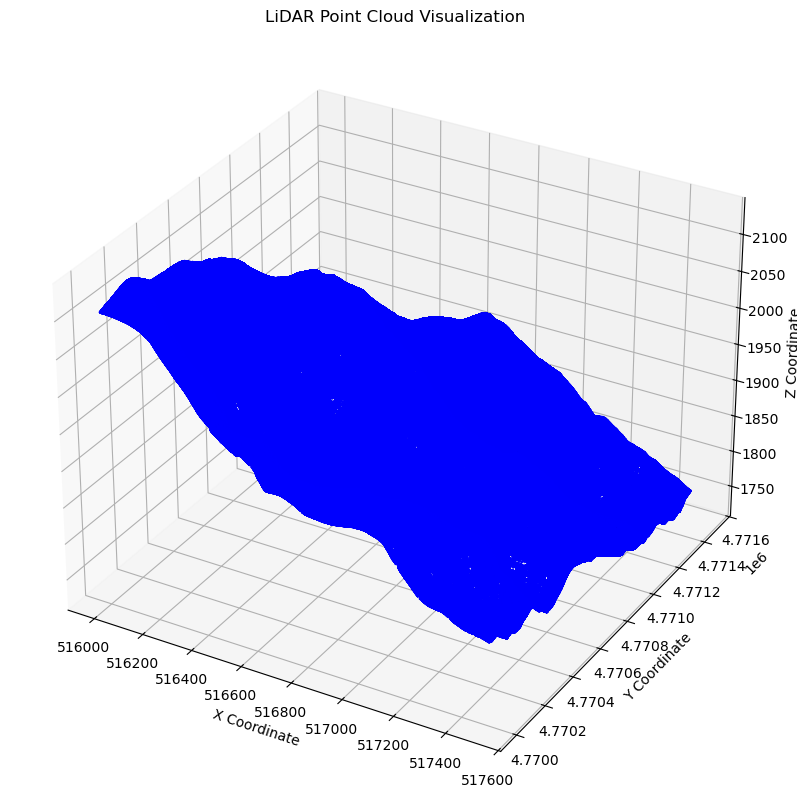

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection="3d")

# Scatter plot of the X, Y, Z coordinates
ax.scatter(data["x"], data["y"], data["z"], s=0.1, c="blue")

# Set labels
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_zlabel("Z Coordinate")

plt.title("LiDAR Point Cloud Visualization")
plt.show()

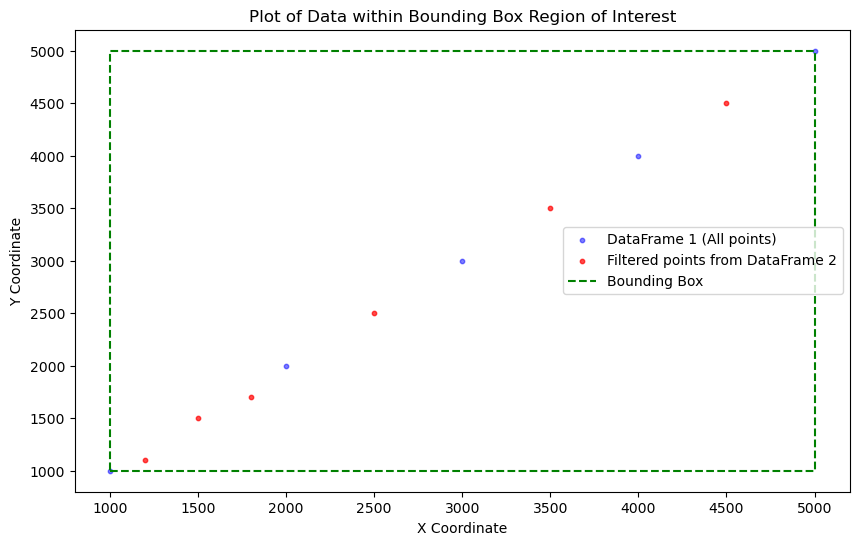

In [15]:
def plot_within_bounding_box(df1, df2):
    """
    Finds the bounding box of the first DataFrame (df1), filters the second DataFrame (df2)
    for points within the bounding box, and plots the results.

    Parameters:
        df1 (DataFrame): The first DataFrame containing the points for defining the bounding box.
        df2 (DataFrame): The second DataFrame containing the points to be filtered by the bounding box.

    Returns:
        None: Displays the plot.
    """

    # Find the bounding box region of interest from df1 (min/max of x and y)
    x_min, x_max = df1["x"].min(), df1["x"].max()
    y_min, y_max = df1["y"].min(), df1["y"].max()

    # Filter df2 to find all points within the bounding box of df1
    df2_filtered = df2[(df2["x"] >= x_min) & (df2["x"] <= x_max) &
                       (df2["y"] >= y_min) & (df2["y"] <= y_max)]

    # Plot the data
    plt.figure(figsize=(10, 6))

    # Plot all points in df1 (whole dataset)
    plt.scatter(df1["x"], df1["y"], c="blue", alpha=0.5, label="DataFrame 1 (All points)", s=10)

    # Plot the selected points from df2 that fall within the bounding box
    plt.scatter(df2_filtered["x"], df2_filtered["y"], c="red", alpha=0.7, label="Filtered points from DataFrame 2", s=10)

    # Highlight the bounding box with a rectangle
    plt.plot([x_min, x_max, x_max, x_min, x_min], 
             [y_min, y_min, y_max, y_max, y_min], 
             color="green", linestyle="--", label="Bounding Box")

    # Labels and title
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.title("Plot of Data within Bounding Box Region of Interest")
    plt.legend()

    # Show the plot
    plt.show()

# Example usage:
# Sample DataFrame 1 (defining the bounding box)
df1 = pd.DataFrame({
    "x": [1000, 2000, 3000, 4000, 5000],
    "y": [1000, 2000, 3000, 4000, 5000]
})

# Sample DataFrame 2 (the points to filter based on the bounding box of df1)
df2 = pd.DataFrame({
    "x": [1500, 2500, 3500, 4500, 1200, 1800],
    "y": [1500, 2500, 3500, 4500, 1100, 1700]
})

# Plot the points
plot_within_bounding_box(df1, df2)

In [50]:
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree

def calculate_airborne_veg_height_utm(airborne_df):
    """
    Computes vegetation height by finding the closest vegetation point (class 3, 4, 5) for each ground photon 
    and calculating the difference in elevation (height).
    
    Parameters:
        airborne_df: The DataFrame containing LiDAR point data with classification and elevation.
        
    Returns:
        DataFrame: Updated DataFrame with vegetation height for each ground photon.
    """

    # Filter photons by classification for canopy (low, medium, high) and ground
    veg_photons = airborne_df[airborne_df["classification"].isin([3, 4, 5])].copy()  # Low, Medium, High Vegetation (class 3, 4, 5)
    ground_photons = airborne_df[airborne_df["classification"] == 2].copy()  # Ground (class 1)

    # Use x and y coordinates for spatial calculations
    ground_photons["coords"] = ground_photons[["x", "y"]].values.tolist()

    # Distance threshold in meters
    distance_threshold = 5  # meters

    # Track used vegetation indices (for unique assignment)
    used_veg_indices = set()

    # Output list for vegetation heights
    veg_heights = []

    # Iterate through each ground photon
    for i, ground in ground_photons.iterrows():
        ground_coord = np.array(ground["coords"])

        # STEP 1: Try finding the closest vegetation point (low, medium, high vegetation)
        if not veg_photons.empty:
            veg_coords = veg_photons[["x", "y"]].values
            veg_tree = cKDTree(veg_coords)
            dist_veg, idx_veg = veg_tree.query(ground_coord, distance_upper_bound=distance_threshold)

            if dist_veg != np.inf and idx_veg not in used_veg_indices:
                vegetation_height = veg_photons.iloc[idx_veg]["z"] - ground["z"]
                veg_heights.append(vegetation_height)
                used_veg_indices.add(idx_veg)
                continue

        # STEP 2: No match found within the distance threshold
        veg_heights.append(0)  # Assign vegetation height as 0 if no match found

    # Assign vegetation height to output DataFrame
    airborne_df_veg_ground = ground_photons.copy()
    airborne_df_veg_ground["vegetation_height"] = veg_heights

    return airborne_df_veg_ground


# Assuming 'icesat2_gdf' is your GeoDataFrame containing the LiDAR data with 'x', 'y', and 'height' columns
result = calculate_airborne_veg_height_utm(data)

# Display the result with vegetation height
print(result[['x', 'y', 'z', 'vegetation_height']].head())

            x           y        z  vegetation_height
0   517499.65  4770292.30  1811.61                  0
3   517491.98  4770310.99  1813.02                  0
5   517485.65  4770299.44  1813.54                  0
11  517488.92  4770334.09  1803.96                  0
18  517496.26  4770284.37  1810.32                  0


In [51]:
result[['vegetation_height']].describe()

,vegetation_height
count,11515624.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [52]:
import pandas as pd
import numpy as np

def compute_average_veg_height(df1, df2, veg_height_column='vegetation_height', box_size=100):
    """
    Computes the average vegetation height for each point in df1 by finding the points within
    a 100m bounding box centered around the point, and averaging their vegetation height from df2.

    Parameters:
    - df1: DataFrame containing the points for which we want to calculate the vegetation height.
    - df2: DataFrame containing the points and vegetation heights to be averaged.
    - veg_height_column: The name of the column in df2 that contains vegetation height values.
    - box_size: The size of the bounding box in meters (default is 100 meters).
    
    Returns:
    - df1: DataFrame with a new column `avg_veg_height` containing the average vegetation height.
    """
    
    # Output list to store the average vegetation height for each point in df1
    avg_veg_heights = []
    
    # Half of the box size
    half_box_size = box_size / 2
    
    # Iterate through each point in df1
    for i, point1 in df1.iterrows():
        # Coordinates of the point in df1
        x1, y1 = point1['x'], point1['y']
        
        # Define the bounding box around the point (100m box)
        x_min, x_max = x1 - half_box_size, x1 + half_box_size
        y_min, y_max = y1 - half_box_size, y1 + half_box_size
        
        # Filter df2 to find points within the bounding box
        bbox_points = df2[(df2['x'] >= x_min) & (df2['x'] <= x_max) &
                           (df2['y'] >= y_min) & (df2['y'] <= y_max)]
        
        # Calculate the average vegetation height for the points within the bounding box
        if not bbox_points.empty:
            avg_veg_height = bbox_points[veg_height_column].mean()
        else:
            avg_veg_height = 0  # If no points are found in the bounding box, set the average to 0
        
        # Append the result to the list
        avg_veg_heights.append(avg_veg_height)
    
    # Add the average vegetation height as a new column to df1
    df1['avg_veg_height'] = avg_veg_heights
    
    return df1

      x     y  avg_veg_height
0  1000  1000            5.50
1  2000  2000            6.00
2  3000  3000            7.65


## Load All Files Together

In [8]:
%%time
import os
import laspy
import pandas as pd
import matplotlib.pyplot as plt

# Folder path containing the .laz files
folder_path = "/bsuhome/tnde/scratch/carbon_estimation/airborne_lidar/test_laz/" 

# Initialize an empty list to hold the data from all files
all_data = []

# Loop through all files in the folder
for file_name in os.listdir(folder_path):
    # Check if the file ends with .laz (case insensitive)
    if file_name.lower().endswith('.laz'):  
        file_path = os.path.join(folder_path, file_name)
        
        # Read the .laz file using laspy
        laz_data = laspy.read(file_path)
        
        # Convert the data to a DataFrame
        df = pd.DataFrame({
            'x': laz_data.x,
            'y': laz_data.y,
            'z': laz_data.z,
            'intensity': laz_data.intensity,
            'return_number': laz_data.return_number,
            'classification': laz_data.classification
        })
        
        # Add the DataFrame to the list
        all_data.append(df)


CPU times: user 19min 15s, sys: 1min 38s, total: 20min 54s
Wall time: 4min 31s


In [9]:
# Concatenate all DataFrames into one
full_data = pd.concat(all_data, ignore_index=True)

# Print the first few rows of the combined DataFrame
print(full_data.head())

                                                   x  \
0  [523914.75, 523910.61, 523922.18, 523929.67, 5...   
1  [523914.75, 523910.61, 523922.18, 523929.67, 5...   
2  [523914.75, 523910.61, 523922.18, 523929.67, 5...   
3  [523914.75, 523910.61, 523922.18, 523929.67, 5...   
4  [523914.75, 523910.61, 523922.18, 523929.67, 5...   

                                                   y  \
0  [4787394.96, 4787362.64, 4787329.01, 4787321.4...   
1  [4787394.96, 4787362.64, 4787329.01, 4787321.4...   
2  [4787394.96, 4787362.64, 4787329.01, 4787321.4...   
3  [4787394.96, 4787362.64, 4787329.01, 4787321.4...   
4  [4787394.96, 4787362.64, 4787329.01, 4787321.4...   

                                                   z  intensity  \
0  [1329.59, 1335.04, 1342.81, 1344.65, 1328.63, ...       1200   
1  [1329.59, 1335.04, 1342.81, 1344.65, 1328.63, ...       1552   
2  [1329.59, 1335.04, 1342.81, 1344.65, 1328.63, ...       1168   
3  [1329.59, 1335.04, 1342.81, 1344.65, 1328.63, ...      

In [10]:
print(len(full_data["classification"].unique()))
print(len(full_data))
full_data = full_data[full_data["classification"].isin([2, 3, 4, 5])]
print(len(full_data))

8
1377150726
780880271


In [12]:
full_data

,x,y,z,intensity,return_number,classification
0,"[523914.75, 523910.61, 523922.18, 523929.67, 5...","[4787394.96, 4787362.64, 4787329.01, 4787321.4...","[1329.59, 1335.04, 1342.81, 1344.65, 1328.63, ...",1200,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2
7,"[523914.75, 523910.61, 523922.18, 523929.67, 5...","[4787394.96, 4787362.64, 4787329.01, 4787321.4...","[1329.59, 1335.04, 1342.81, 1344.65, 1328.63, ...",1568,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2
10,"[523914.75, 523910.61, 523922.18, 523929.67, 5...","[4787394.96, 4787362.64, 4787329.01, 4787321.4...","[1329.59, 1335.04, 1342.81, 1344.65, 1328.63, ...",1264,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2
11,"[523914.75, 523910.61, 523922.18, 523929.67, 5...","[4787394.96, 4787362.64, 4787329.01, 4787321.4...","[1329.59, 1335.04, 1342.81, 1344.65, 1328.63, ...",1536,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2
15,"[523914.75, 523910.61, 523922.18, 523929.67, 5...","[4787394.96, 4787362.64, 4787329.01, 4787321.4...","[1329.59, 1335.04, 1342.81, 1344.65, 1328.63, ...",1504,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2
...,...,...,...,...,...,...
1377150698,"[521952.48000000004, 521973.81, 521999.01, 521...","[4782440.93, 4782610.24, 4782230.88, 4782233.7...","[1267.82, 1281.91, 1270.6200000000001, 1270.65...",2192,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2
1377150707,"[521952.48000000004, 521973.81, 521999.01, 521...","[4782440.93, 4782610.24, 4782230.88, 4782233.7...","[1267.82, 1281.91, 1270.6200000000001, 1270.65...",2032,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2
1377150708,"[521952.48000000004, 521973.81, 521999.01, 521...","[4782440.93, 4782610.24, 4782230.88, 4782233.7...","[1267.82, 1281.91, 1270.6200000000001, 1270.65...",1888,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2
1377150711,"[521952.48000000004, 521973.81, 521999.01, 521...","[4782440.93, 4782610.24, 4782230.88, 4782233.7...","[1267.82, 1281.91, 1270.6200000000001, 1270.65...",1904,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2


ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not 0             [1329.59, 1335.04, 1342.81, 1344.65, 1328.63, ...
7             [1329.59, 1335.04, 1342.81, 1344.65, 1328.63, ...
10            [1329.59, 1335.04, 1342.81, 1344.65, 1328.63, ...
11            [1329.59, 1335.04, 1342.81, 1344.65, 1328.63, ...
15            [1329.59, 1335.04, 1342.81, 1344.65, 1328.63, ...
                                    ...                        
1377150698    [1267.82, 1281.91, 1270.6200000000001, 1270.65...
1377150707    [1267.82, 1281.91, 1270.6200000000001, 1270.65...
1377150708    [1267.82, 1281.91, 1270.6200000000001, 1270.65...
1377150711    [1267.82, 1281.91, 1270.6200000000001, 1270.65...
1377150721    [1267.82, 1281.91, 1270.6200000000001, 1270.65...
Name: z, Length: 780880271, dtype: object

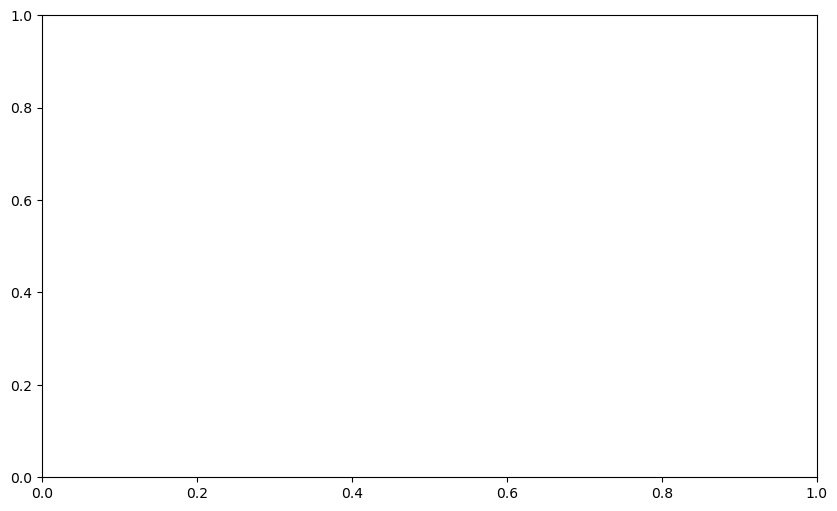

In [14]:
# If the 'z' column contains lists, extract the first element from each list
full_data['z'] = full_data['z'].apply(lambda x: x[0] if isinstance(x, list) else x)

# Now proceed with the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(full_data['x'], full_data['y'], c=full_data['z'], cmap='viridis', s=0.5)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('LiDAR Point Cloud (X, Y, Z)')
plt.colorbar(label='Z Coordinate')
plt.show()


In [13]:
1

1